# BATTLE OF NEIGHBORHOODS - VENUE RECOMMENDATION FOR A NEW VEGETERIAN RESTAURANT IN RUSSIA 

## Applied Data Science Capstone Project Coursera

## Table of contents:



- Introduction: Business Problem
- Data Acquisition
- Methodology
- Analysis
- Results and Discussion
- Conclusion

## Introduction: Business Problem

In this project I would like to solve imaginary case.
One foreign Investor (customer) wants to invest and open vegan cafe in one of the city of Russia.
After a meeting with him, he defined his business aim and informed me about the criteria’s like following, it should be:
1. Opened in one of the big Cities of Russia (Population over 100.000 and more).
2. Within the max. 15 minutes walking distance from the Geographical coordinates of the City Center
3. As far away from other vegan cafe as possible
4. As close as possible to Hotels, because guests of the in-city hotels are generally tended to eat vegan cuisine nearby.
5. Population of the city also counts as a positive measure too. (City should be as crowded as possible)

In [72]:

#Importing all the libraries
import pandas as pd # library for data analsysis
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import seaborn as sns

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

# install the Geocoder

import geocoder


import folium # map rendering library
from folium import plugins

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


## Data Acquisition

I found csv file of Russian cities with their population and download it.

In [2]:
import pandas as pd

russian_cities = pd.read_csv("ru.csv")
russian_cities = russian_cities[["city", "population", "lat", "lng"]]
russian_cities.head()

,city,population,lat,lng
0,Moscow,10452000.0,55.752222,37.615556
1,Saint Petersburg,4553000.0,59.894444,30.264167
2,Novosibirsk,1389000.0,55.041500,82.934600
3,Yekaterinburg,1313000.0,56.851900,60.612200
4,Nizhniy Novgorod,1278000.0,56.326944,44.007500


In [6]:
russian_cities = russian_cities.sort_values(by=["population"], ascending = False).head(25)

Second source is a source about venues. I will get this data from Foursquare

The FourSquare API will be used to explore  Russian Cities.  The following information is retrieved:

- Venue ID
- Venue Name
- Venue Coordinates i.e. Latitude and Longitude
- Venue Category

 And I will describe some points which I'm going to solve in this project

1. This is already satisfied because we have fetched cities only with population >100k.
2. Within the max. 15 minutes walking distance from the Geographical coordinates of the City Center.
This request is converted to an variable to use in Foursquare Api call (Radius = 1250 meters in search).
3. As far away from other vegan cafe as possible.
4. As close as possible to Hotels.
5. Population value is directly related to the number of potential customers. 

## Analysis

### Creating A Folium map for (Initial) Visualizing of Concerned Cities

In [7]:
address = 'Russia, Moscow'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Moscow City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Moscow City are 55.7504461, 37.6174943.


In [8]:
map_Russian_Cities = folium.Map(location=[55.7504461, 37.6174943], zoom_start=6)

# add markers to map
for lat, lng, city in zip(russian_cities['lat'], russian_cities['lng'], russian_cities['city']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Russian_Cities)  
    
map_Russian_Cities

#### Connect to foursquare api

In [9]:
CLIENT_ID = 'RVAAROEXNCVKZXUVT1IEK0RGOXJYKMDXSP41TQSFZFTAOSNE' # your Foursquare ID
CLIENT_SECRET = 'MYW3VUYJFAYS0K0Q04IYTBU3QNOTK1QOZC4D53CN0G0KU2UC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RVAAROEXNCVKZXUVT1IEK0RGOXJYKMDXSP41TQSFZFTAOSNE
CLIENT_SECRET:MYW3VUYJFAYS0K0Q04IYTBU3QNOTK1QOZC4D53CN0G0KU2UC


In [83]:
radius = 1250
LIMIT = 300
search_query = 'Vegetarian / Vegan Restaurant'

In [92]:
def getVenues(city, latitudes, longitudes, radius=500):
    
    search_list=[]
    for city, lat, lng in zip(city, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
      
        # return only relevant information for each nearby venue
        search_list.append([(
            city, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    search_venues = pd.DataFrame([item for search_list in search_list for item in search_list])

    search_venues.columns = ['city',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue ID',           
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(search_venues)

In [93]:
#Getting Indian restaurants for suburbs in all LGAs of Adelaide in a dataframe
VegeterianRestaurants = getVenues(city=russian_cities['city'],
                                   latitudes=russian_cities['lat'],
                                   longitudes=russian_cities['lng']
                                  )

In [97]:
VegeterianRestaurants

,city,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category
0,Novosibirsk,55.041500,82.934600,Bellagio Vegan Restaurant,575d9f58498e1d519adf8a70,55.042810,82.936668,Vegetarian / Vegan Restaurant
1,Yekaterinburg,56.851900,60.612200,Диет-веган,52667263498ee19d82585216,56.854134,60.613049,Vegetarian / Vegan Restaurant
2,Nizhniy Novgorod,56.326944,44.007500,Hi Mir cafe,5af715aba89b5a002faf8728,56.323570,44.009954,Vegetarian / Vegan Restaurant
3,Nizhniy Novgorod,56.326944,44.007500,Морковка,57b1e46e498e8531b72f2a50,56.325120,44.010660,Vegetarian / Vegan Restaurant
4,Kazan’,55.788740,49.122144,eco shop,57309595498e5172f6efc00c,55.788425,49.120992,Vegetarian / Vegan Restaurant
5,Kazan’,55.788740,49.122144,Holy Bali,5c9789a3a3061900391f53de,55.789340,49.123890,Vegetarian / Vegan Restaurant
6,Kazan’,55.788740,49.122144,Green Life,58c927829f258314834780e5,55.788610,49.121204,Vegetarian / Vegan Restaurant
7,Kazan’,55.788740,49.122144,ECO FOOD,576a48b7498e0e7a22251fa8,55.788379,49.121558,Vegetarian / Vegan Restaurant


In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
Russian_venues = getNearbyVenues(names = russian_cities['city'], latitudes = russian_cities['lat'], longitudes= russian_cities['lng'] )
Russian_venues.shape
Russian_venues.head(5)

Moscow
Saint Petersburg
Novosibirsk
Yekaterinburg
Nizhniy Novgorod
Samara
Omsk
Kazan’
Chelyabinsk
Rostov-na-Donu
Ufa
Perm’
Volgograd
Krasnoyarsk
Voronezh
Saratov
Krasnodar
Ul’yanovsk
Izhevsk
Yaroslavl’
Barnaul
Vladivostok
Irkutsk
Khabarovsk
Makhachkala


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Moscow,55.752222,37.615556,Aleksandrovskiy Garden (Александровский сад),55.752707,37.613733,Park
1,Moscow,55.752222,37.615556,The Kremlin (Кремль),55.751999,37.617734,Government Building
2,Moscow,55.752222,37.615556,Cathedral Square (Соборная площадь),55.750677,37.617442,Plaza
3,Moscow,55.752222,37.615556,Музеи Московского Кремля,55.751789,37.616477,History Museum
4,Moscow,55.752222,37.615556,Manege Central Exhibition Hall (ЦВЗ «Манеж»),55.753378,37.612360,Event Space


In [38]:
Russian_venues.shape

(554, 7)

### Let's check how many venues were returned for each City

In [39]:
Russian_venues[['Venue Category','Venue']].groupby(Russian_venues['City']).count().head(10)

,Venue Category,Venue
City,,
Barnaul,7,7
Chelyabinsk,2,2
Irkutsk,2,2
Izhevsk,44,44
Kazan’,74,74
Khabarovsk,15,15
Krasnodar,45,45
Krasnoyarsk,4,4
Makhachkala,18,18


In [96]:
VegeterianRestaurants[['Venue Category','Venue']].groupby(VegeterianRestaurants['city']).count().head(10)

,Venue Category,Venue
city,,
Kazan’,4,4
Nizhniy Novgorod,2,2
Novosibirsk,1,1
Yekaterinburg,1,1


### Let's find out how many unique categories can be curated from all the returned venues

In [40]:
print('There are {} uniques categories.'.format(len(Russian_venues['Venue Category'].unique())))

There are 159 uniques categories.


In [41]:
# one hot encoding
Russian_onehot = pd.get_dummies(Russian_venues[['Venue Category']], prefix="", prefix_sep="")

In [42]:
Russian_onehot.head()

,ATM,American Restaurant,Antique Shop,Art Gallery,Art Museum,Asian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Betting Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Fish Market,Fishing Store,Flower Shop,Fountain,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,German Restaurant,Gift Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Karaoke Bar,Korean Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Optical Shop,Outdoor Sculpture,Palace,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool Hall,Pub,Public Art,Recreation Center,Restaurant,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Theater,Toy / Game Store,Tram Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
Russia_grouped = Russian_onehot.groupby(Russian_venues['City']).mean().reset_index()

In [45]:
Russia_grouped = Russia_grouped.round(decimals=2)

In [46]:
Russia_grouped.head()

,City,ATM,American Restaurant,Antique Shop,Art Gallery,Art Museum,Asian Restaurant,Automotive Shop,BBQ Joint,Baby Store,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Betting Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Caucasian Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Fish Market,Fishing Store,Flower Shop,Fountain,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,German Restaurant,Gift Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Historic Site,History Museum,Hockey Arena,Hookah Bar,Hostel,Hotel,Ice Cream Shop,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Karaoke Bar,Korean Restaurant,Library,Light Rail Station,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Nightclub,Noodle House,Optical Shop,Outdoor Sculpture,Palace,Park,Pedestrian Plaza,Pelmeni House,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pizza Place,Playground,Plaza,Pool Hall,Pub,Public Art,Recreation Center,Restaurant,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tailor Shop,Tea Room,Tennis Court,Theater,Toy / Game Store,Tram Station,Turkish Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,Barnaul,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.14,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.14,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.14,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.14,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.14,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.14,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.14,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00
1,Chelyabinsk,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.50,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.50,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00
2,Irkutsk,0.0,0.00,0.0,0.00,0.0,0.00,0.5,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,

In [47]:
Russia_grouped.shape

(25, 160)

In [48]:
num_top_venues = 10

for x in Russia_grouped['City']:
    print("----"+x+"----")
    temp = Russia_grouped[Russia_grouped['City'] == x].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barnaul----
                   venue  freq
0              Irish Pub  0.14
1         Clothing Store  0.14
2      Mobile Phone Shop  0.14
3   Fast Food Restaurant  0.14
4                Theater  0.14
5          Shopping Mall  0.14
6                  Plaza  0.14
7  Performing Arts Venue  0.00
8          Pelmeni House  0.00
9              Pet Store  0.00


----Chelyabinsk----
               venue  freq
0  Electronics Store   0.5
1               Café   0.5
2                ATM   0.0
3          Pool Hall   0.0
4          Nightclub   0.0
5       Noodle House   0.0
6       Optical Shop   0.0
7  Outdoor Sculpture   0.0
8             Palace   0.0
9               Park   0.0


----Irkutsk----
               venue  freq
0      Pelmeni House   0.5
1    Automotive Shop   0.5
2   Pedestrian Plaza   0.0
3        Music Venue   0.0
4          Nightclub   0.0
5       Noodle House   0.0
6       Optical Shop   0.0
7  Outdoor Sculpture   0.0
8             Palace   0.0
9               Park   0.0


----Izh

### First, let's write a function to sort the venues in descending order.

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
City_venues_sorted = pd.DataFrame(columns=columns)
City_venues_sorted['City'] = Russia_grouped['City']

for ind in np.arange(Russia_grouped.shape[0]):
    City_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Russia_grouped.iloc[ind, :], num_top_venues)

City_venues_sorted

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Barnaul,Mobile Phone Shop,Clothing Store,Shopping Mall,Theater,Fast Food Restaurant,Plaza,Irish Pub,Dessert Shop,Event Space,Electronics Store,Eastern European Restaurant,Convenience Store,Donut Shop,Diner,Cosmetics Shop
1,Chelyabinsk,Electronics Store,Café,Zoo Exhibit,Comfort Food Restaurant,Fish Market,Fast Food Restaurant,Event Space,Eastern European Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio,Department Store,Deli / Bodega,Dance Studio
2,Irkutsk,Automotive Shop,Pelmeni House,Zoo Exhibit,Dessert Shop,Fish Market,Fast Food Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Donut Shop,Diner,Design Studio,Flower Shop,Department Store,Deli / Bodega
3,Izhevsk,Café,Coffee Shop,Gym / Fitness Center,Pub,Clothing Store,Fast Food Restaurant,Deli / Bodega,Caucasian Restaurant,Climbing Gym,College Gym,Performing Arts Venue,Comfort Food Restaurant,Concert Hall,Park,Cosmetics Shop
4,Kazan’,Coffee Shop,Hotel,Bar,Café,Hostel,Restaurant,Wine Bar,Hookah Bar,Park,Gastropub,Gym,Pizza Place,Noodle House,Pedestrian Plaza,Plaza
5,Khabarovsk,Theater,Café,Boutique,Restaurant,Bus Line,Sports Bar,Clothing Store,Pub,Coffee Shop,Performing Arts Venue,Hockey Arena,Middle Eastern Restaurant,Park,Hotel,Pedestrian Plaza
6,Krasnodar,Café,Electronics Store,Fast Food Restaurant,Restaurant,Pizza Place,Bar,Coffee Shop,Eastern European Restaurant,Italian Restaurant,Zoo Exhibit,Light Rail Station,Sculpture Garden,Pharmacy,Park,Mobile Phone Shop
7,Krasnoyarsk,Caucasian Restaurant,Hookah Bar,Photography Studio,Gym Pool,Zoo Exhibit,Fast Food Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Donut Shop,Diner,Dessert Shop,Department Store,Design Studio,Fishing Store
8,Makhachkala,Café,Mobile Phone Shop,Eastern European Restaurant,Coffee Shop,Pharmacy,Caucasian Restaurant,Restaurant,Snack Place,Turkish Restaurant,Fast Food Restaurant,Japanese Restaurant,Gym Pool,Halal Restaurant,Ice Cream Shop,Czech Restaurant
9,Moscow,Boutique,History Museum,Plaza,Shoe Store,Fountain,Bookstore,Jewelry Store,Coffee Shop,Cosmetics Shop,Ice Cream Shop,Clothing Store,Palace,Historic Site,Event Space,Shopping Mall


## Clustering Cities with K-Means MLA

In [52]:
# set number of clusters
kclusters = 6

Russian_clustering = Russia_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Russian_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1, 0, 0, 0, 0, 5, 0, 0])

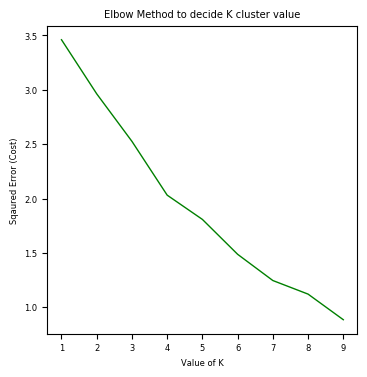

In [53]:
cost =[] 
for i in range(1, 10): 
    KM = KMeans(n_clusters=i, max_iter = 100).fit(Russian_clustering)
    
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams.update({'font.size': 6})
plt.title('Elbow Method to decide K cluster value')
plt.plot(range(1, 10), cost, color ='g', linewidth ='1') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()



In [58]:
City_venues_sorted

,Cluster Labels,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,0,Barnaul,Mobile Phone Shop,Clothing Store,Shopping Mall,Theater,Fast Food Restaurant,Plaza,Irish Pub,Dessert Shop,Event Space,Electronics Store,Eastern European Restaurant,Convenience Store,Donut Shop,Diner,Cosmetics Shop
1,2,Chelyabinsk,Electronics Store,Café,Zoo Exhibit,Comfort Food Restaurant,Fish Market,Fast Food Restaurant,Event Space,Eastern European Restaurant,Donut Shop,Diner,Dessert Shop,Design Studio,Department Store,Deli / Bodega,Dance Studio
2,1,Irkutsk,Automotive Shop,Pelmeni House,Zoo Exhibit,Dessert Shop,Fish Market,Fast Food Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Donut Shop,Diner,Design Studio,Flower Shop,Department Store,Deli / Bodega
3,0,Izhevsk,Café,Coffee Shop,Gym / Fitness Center,Pub,Clothing Store,Fast Food Restaurant,Deli / Bodega,Caucasian Restaurant,Climbing Gym,College Gym,Performing Arts Venue,Comfort Food Restaurant,Concert Hall,Park,Cosmetics Shop
4,0,Kazan’,Coffee Shop,Hotel,Bar,Café,Hostel,Restaurant,Wine Bar,Hookah Bar,Park,Gastropub,Gym,Pizza Place,Noodle House,Pedestrian Plaza,Plaza
5,0,Khabarovsk,Theater,Café,Boutique,Restaurant,Bus Line,Sports Bar,Clothing Store,Pub,Coffee Shop,Performing Arts Venue,Hockey Arena,Middle Eastern Restaurant,Park,Hotel,Pedestrian Plaza
6,0,Krasnodar,Café,Electronics Store,Fast Food Restaurant,Restaurant,Pizza Place,Bar,Coffee Shop,Eastern European Restaurant,Italian Restaurant,Zoo Exhibit,Light Rail Station,Sculpture Garden,Pharmacy,Park,Mobile Phone Shop
7,5,Krasnoyarsk,Caucasian Restaurant,Hookah Bar,Photography Studio,Gym Pool,Zoo Exhibit,Fast Food Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Donut Shop,Diner,Dessert Shop,Department Store,Design Studio,Fishing Store
8,0,Makhachkala,Café,Mobile Phone Shop,Eastern European Restaurant,Coffee Shop,Pharmacy,Caucasian Restaurant,Restaurant,Snack Place,Turkish Restaurant,Fast Food Restaurant,Japanese Restaurant,Gym Pool,Halal Restaurant,Ice Cream Shop,Czech Restaurant
9,0,Moscow,Boutique,History Museum,Plaza,Shoe Store,Fountain,Bookstore,Jewelry Store,Coffee Shop,Cosmetics Shop,Ice Cream Shop,Clothing Store,Palace,Historic Site,Event Space,Shopping Mall


In [61]:
Russian_merged

,city,population,lat,lng
0,Moscow,10452000.0,55.752222,37.615556
1,Saint Petersburg,4553000.0,59.894444,30.264167
2,Novosibirsk,1389000.0,55.041500,82.934600
3,Yekaterinburg,1313000.0,56.851900,60.612200
4,Nizhniy Novgorod,1278000.0,56.326944,44.007500
5,Samara,1137000.0,53.200065,50.150002
6,Omsk,1135000.0,55.000000,73.400000
7,Kazan’,1115000.0,55.788740,49.122144
8,Chelyabinsk,1091000.0,55.154015,61.429150
9,Rostov-na-Donu,1052000.0,47.231350,39.723284


In [ ]:
# Here we add the clustering labels
City_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Russian_merged = russian_cities

In [63]:
# Lets merge City_venues_sorted with df1 to add latitude/longitude for each City
Russian_merged = Russian_merged.join(City_venues_sorted.set_index('City'), on="city")

Russian_merged.head() # check the last columns!

,city,population,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Moscow,10452000.0,55.752222,37.615556,0,Boutique,History Museum,Plaza,Shoe Store,Fountain,Bookstore,Jewelry Store,Coffee Shop,Cosmetics Shop,Ice Cream Shop,Clothing Store,Palace,Historic Site,Event Space,Shopping Mall
1,Saint Petersburg,4553000.0,59.894444,30.264167,0,Supermarket,Soccer Field,Yoga Studio,Bistro,Park,Tram Station,Theater,Dessert Shop,Fast Food Restaurant,Event Space,Electronics Store,Eastern European Restaurant,Donut Shop,Diner,Zoo Exhibit
2,Novosibirsk,1389000.0,55.041500,82.934600,0,Café,Fast Food Restaurant,BBQ Joint,Pizza Place,Diner,Sporting Goods Shop,Furniture / Home Store,Fishing Store,Bistro,Shoe Store,Bus Stop,Karaoke Bar,Toy / Game Store,Flower Shop,Bar
3,Yekaterinburg,1313000.0,56.851900,60.612200,0,Eastern European Restaurant,Gym / Fitness Center,Middle Eastern Restaurant,Bakery,Mobile Phone Shop,Boutique,Cafeteria,Caucasian Restaurant,Music Venue,Nightclub,Spa,Japanese Restaurant,Pizza Place,Dessert Shop,Fish Market
4,Nizhniy Novgorod,1278000.0,56.326944,44.007500,0,Coffee Shop,Café,Restaurant,Hostel,Italian Restaurant,Scenic Lookout,Caucasian Restaurant,Historic Site,Art Museum,Burger Joint,Concert Hall,Grocery Store,Steakhouse,Pub,Park


In [65]:
# create map
map_clusters = folium.Map(location=[55.7504461, 37.6174943], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Russian_merged['lat'], Russian_merged['lng'], Russian_merged['city'], Russian_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [66]:
pd.set_option('display.max_colwidth', -1)

df_pretty = Russian_merged.groupby('Cluster Labels')['city'].apply(', '.join)

df_pretty.reset_index().style.hide_index()

Cluster Labels,city
0,"Moscow, Saint Petersburg, Novosibirsk, Yekaterinburg, Nizhniy Novgorod, Samara, Kazan’, Rostov-na-Donu, Perm’, Volgograd, Voronezh, Saratov, Krasnodar, Ul’yanovsk, Izhevsk, Yaroslavl’, Barnaul, Vladivostok, Khabarovsk, Makhachkala"
1,Irkutsk
2,Chelyabinsk
3,Omsk
4,Ufa
5,Krasnoyarsk


In [69]:
Russian_grouped2= Russia_grouped.set_index('City').transpose()

In [70]:
Russian_grouped2.style.background_gradient(cmap="Greens", low = 0, high = 0.3)

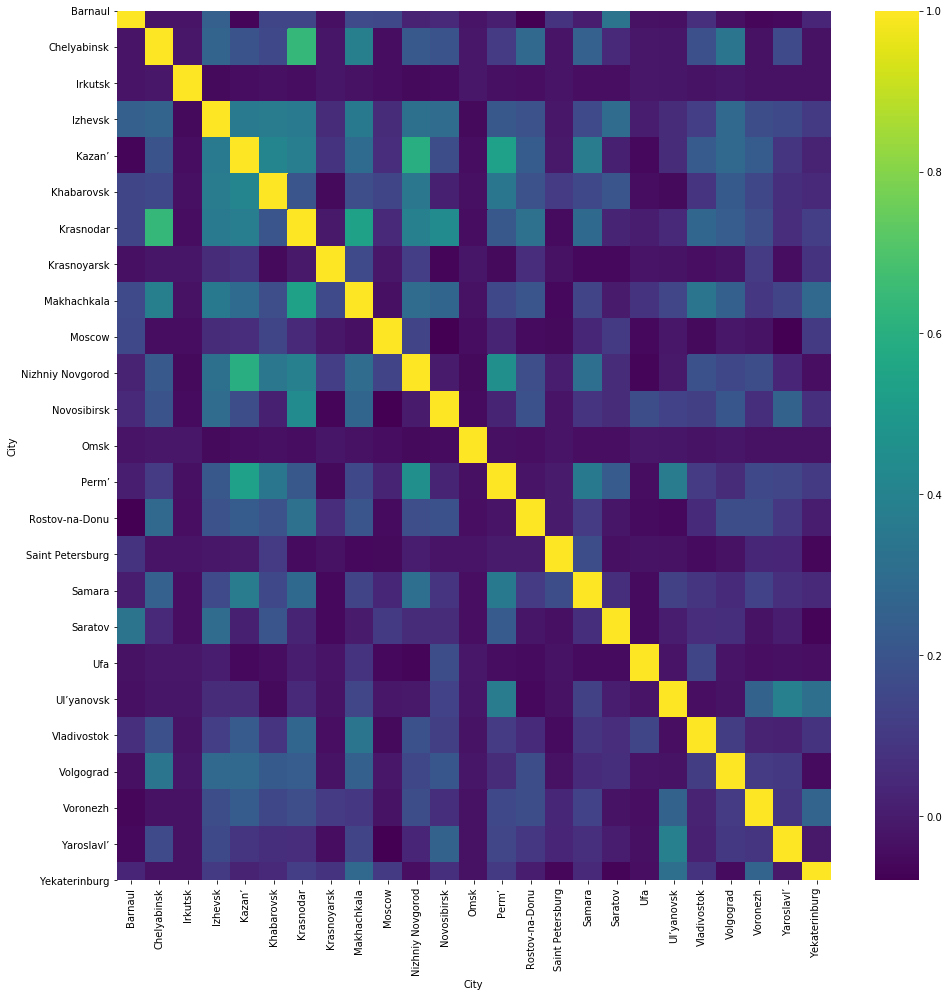

In [73]:
RU_Corr = Russian_grouped2.corr()

# plot the correlation heatmap
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams.update({'font.size': 10})
sns.heatmap(RU_Corr, xticklabels=RU_Corr.columns, yticklabels=RU_Corr.columns, cmap='viridis', annot=False)

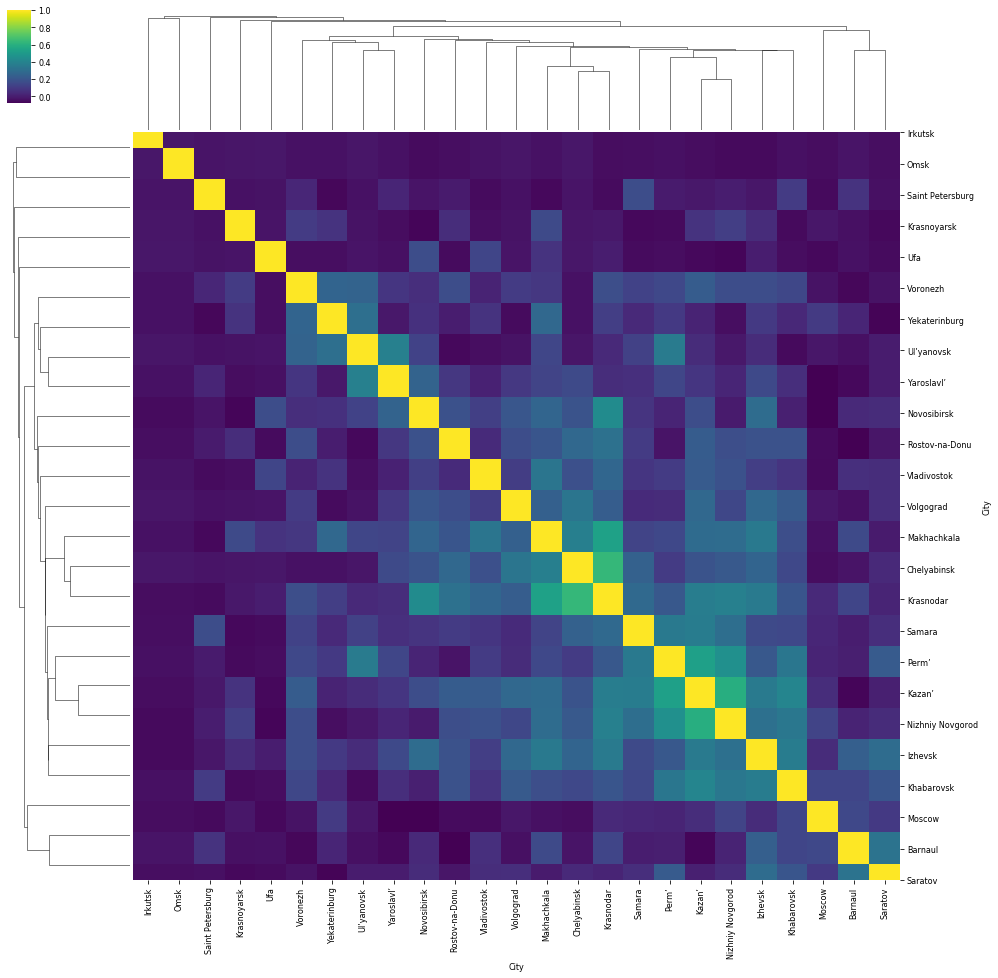

In [74]:
RU_Corr = Russian_grouped2.corr()

%matplotlib inline
plt.rcParams.update({'font.size': 8})
sns.clustermap(RU_Corr, xticklabels=RU_Corr.columns, yticklabels=RU_Corr.columns, cmap='viridis', annot=False, method="single",figsize=(16,16))

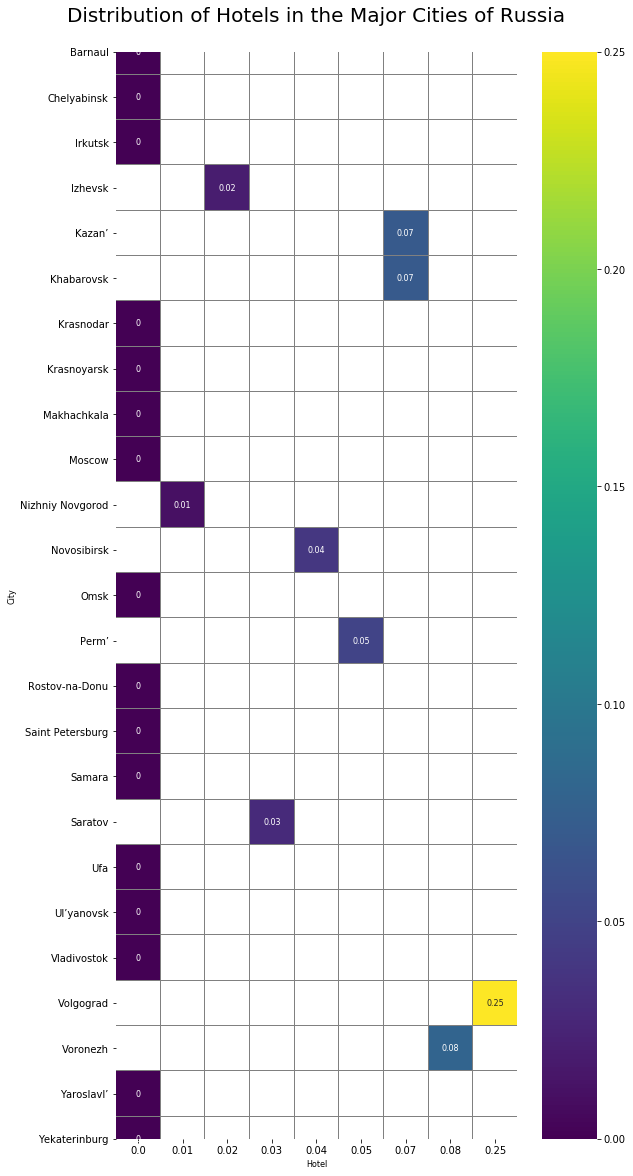

In [76]:
# below is the Generic code to see desired business , please just play with the Target_Business '' variable to see results of the different business / venues .

Target_Business ='Hotel'

result = Russia_grouped.pivot(index='City', columns=Target_Business, values=Target_Business)


plt.rcParams.update(plt.rcParamsDefault)

%matplotlib inline

#sns.set(context='paper', style='white', palette='deep', font='sans-serif', font_scale=1 , color_codes=True, rc=None)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10) # fontsize of the tick labels
plt.rcParams['figure.figsize'] = [9, 20]
#plt.rc('figure', titlesize=30) 
plt.rcParams.update({'font.size': 8})
plt.title('Distribution of Hotels in the Major Cities of Russia', fontdict = {'fontsize' : 20}, pad=30)
sns.heatmap(result, annot=True, cmap='viridis', linewidths = 0.01 , linecolor='grey', cbar=True, fmt="g")

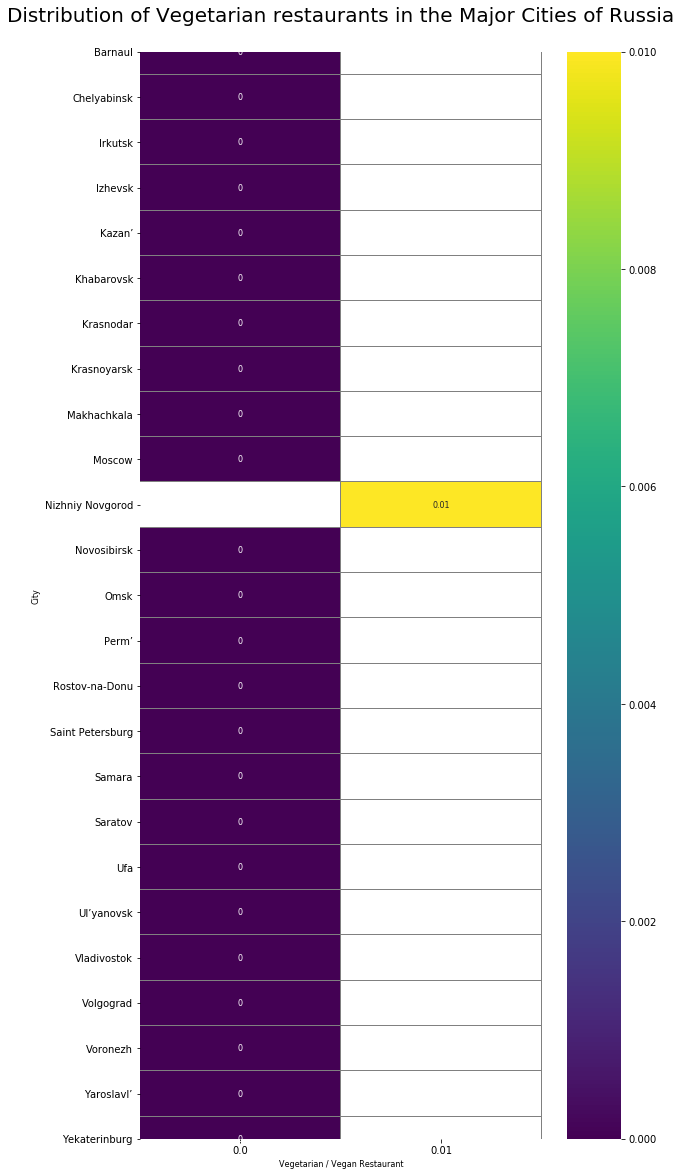

In [78]:

# below is the Generic code to see desired business , please just play with the Target_Business '' variable to see results of the different business / venues .

Target_Business ='Vegetarian / Vegan Restaurant'

result = Russia_grouped.pivot(index='City', columns=Target_Business, values=Target_Business)


plt.rcParams.update(plt.rcParamsDefault)

%matplotlib inline

#sns.set(context='paper', style='white', palette='deep', font='sans-serif', font_scale=1 , color_codes=True, rc=None)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10) # fontsize of the tick labels
plt.rcParams['figure.figsize'] = [9, 20]
#plt.rc('figure', titlesize=30) 
plt.rcParams.update({'font.size': 8})
plt.title('Distribution of Vegetarian restaurants in the Major Cities of Russia', fontdict = {'fontsize' : 20}, pad=30)
sns.heatmap(result, annot=True, cmap='viridis', linewidths = 0.01 , linecolor='grey', cbar=True, fmt="g")

In [112]:
customer_says = [['away from other vegeterian restaurant',  'Positive'],  ['close to Hotels', 'Positive'], \
                   ['highest possible population ', 'Positive'], ["Within the max. 15 minutes walking distance from the Geographical coordinates of the City Center", "Positive"]] 

# Create the pandas DataFrame 
Wishes_Matrix = pd.DataFrame(customer_says, columns = ['Requirement','Correlation'])

Wishes_Matrix

,Requirement,Correlation
0,away from other vegeterian restaurant,Positive
1,close to Hotels,Positive
2,highest possible population,Positive
3,Within the max. 15 minutes walking distance from the Geographical coordinates of the City Center,Positive


In [119]:
Custumer_Venues = Russia_grouped[['City','Vegetarian / Vegan Restaurant',  'Hotel']].copy()

In [121]:
Custumer_Venues.sort_values(by=['Vegetarian / Vegan Restaurant', "Hotel"], ascending=False)

,City,Vegetarian / Vegan Restaurant,Hotel
10,Nizhniy Novgorod,0.01,0.01
21,Volgograd,0.00,0.25
22,Voronezh,0.00,0.08
4,Kazan’,0.00,0.07
5,Khabarovsk,0.00,0.07
13,Perm’,0.00,0.05
11,Novosibirsk,0.00,0.04
17,Saratov,0.00,0.03
3,Izhevsk,0.00,0.02
0,Barnaul,0.00,0.00


In [132]:
Customer_Social = Russian_merged[['city','population']].copy()
Customer_Social.rename(columns={"city": "City"}, inplace=True)
Customer_Social.head(10)

,City,population
0,Moscow,10452000.0
1,Saint Petersburg,4553000.0
2,Novosibirsk,1389000.0
3,Yekaterinburg,1313000.0
4,Nizhniy Novgorod,1278000.0
5,Samara,1137000.0
6,Omsk,1135000.0
7,Kazan’,1115000.0
8,Chelyabinsk,1091000.0
9,Rostov-na-Donu,1052000.0


In [133]:
Customer_Merged = Custumer_Venues.merge(Customer_Social, on="City")

Customer_Merged

,City,Vegetarian / Vegan Restaurant,Hotel,population
0,Barnaul,0.00,0.00,599579.0
1,Chelyabinsk,0.00,0.00,1091000.0
2,Irkutsk,0.00,0.00,586695.0
3,Izhevsk,0.00,0.02,631038.0
4,Kazan’,0.00,0.07,1115000.0
5,Khabarovsk,0.00,0.07,579000.0
6,Krasnodar,0.00,0.00,649851.0
7,Krasnoyarsk,0.00,0.00,925000.0
8,Makhachkala,0.00,0.00,554981.0
9,Moscow,0.00,0.00,10452000.0


In [135]:
Customer_Merged = Customer_Merged.set_index('City')

In [136]:
Customer_Merged.head()

,Vegetarian / Vegan Restaurant,Hotel,population
City,,,
Barnaul,0.0,0.00,599579.0
Chelyabinsk,0.0,0.00,1091000.0
Irkutsk,0.0,0.00,586695.0
Izhevsk,0.0,0.02,631038.0
Kazan’,0.0,0.07,1115000.0


In [137]:
for i in Customer_Merged.columns:
    print('Max value of',i,':',Customer_Merged[i].max())

Max value of Vegetarian / Vegan Restaurant : 0.01
Max value of Hotel : 0.25
Max value of population : 10452000.0


In [138]:
for i in Customer_Merged.columns:
    Customer_Merged[i]= Customer_Merged[i]/Customer_Merged[i].max()

In [141]:
#Normalized view of the Data Frame 
Customer_Merged.sort_values(by=['Vegetarian / Vegan Restaurant', "Hotel", "population"], ascending=False)

,Vegetarian / Vegan Restaurant,Hotel,population
City,,,
Nizhniy Novgorod,1.0,0.04,0.122273
Volgograd,0.0,1.00,0.094145
Voronezh,0.0,0.32,0.080750
Kazan’,0.0,0.28,0.106678
Khabarovsk,0.0,0.28,0.055396
Perm’,0.0,0.20,0.095388
Novosibirsk,0.0,0.16,0.132893
Saratov,0.0,0.12,0.080654
Izhevsk,0.0,0.08,0.060375


In [142]:
Customer_Merged['Total_Score'] = Customer_Merged.sum(axis=1)

In [144]:
Customer_Merged.sort_values(by='Total_Score', ascending=False).head(20)

,Vegetarian / Vegan Restaurant,Hotel,population,Total_Score
City,,,,
Nizhniy Novgorod,1.0,0.04,0.122273,1.162273
Volgograd,0.0,1.00,0.094145,1.094145
Moscow,0.0,0.00,1.000000,1.000000
Saint Petersburg,0.0,0.00,0.435610,0.435610
Voronezh,0.0,0.32,0.080750,0.400750
Kazan’,0.0,0.28,0.106678,0.386678
Khabarovsk,0.0,0.28,0.055396,0.335396
Perm’,0.0,0.20,0.095388,0.295388
Novosibirsk,0.0,0.16,0.132893,0.292893


## Our Final List to advice to the Customer would be :

- Nizhniy Novgorod
- Volgograd	
- Moscow
- Saint Petersburg	
- Voronezh

## Discussion about further improvement possibilities

Like in every engineering problem happens we have also made some assumptions and simplifications to understand and present solution in a better way. One of the biggest problems in this project, I would say source of the Venue Data. We are using a USA based Data supplier , Foursquare to judge places venues in the Russia , this data seem to be missing and in some parts are not suitable to our problem. Tagging of venues are made from the Foursquare users , I am assuming they are mainly not Russian. It is highly possible some of venues are wrong tagged or skipped, not listed in api call results. So, as a further improvement one can go professional and buy a real data set especially prepared for the Russia (or any other country in your analyzes).

## Conclusion

In this project I wanted to create and solve a real-life problem rather than repeating the classical clustering assignment from our course. I made this assignment much more complicated than the necessary and because of that, I have to spent too much time than the normal case as you appreciate. But just because of that complexity and, having no example in front of me, I have learned too many things from this project. I had to think and find ideas myself like, weight matrix, customer wishes, adapting all those to still our assignment guidelines. So, it may include some wrong conceptions, but still I hope enjoy reading and evaluating it. I hope this project will help me the find a right role in the Data Science world.